# 1. LSTM and GRU for classification

### Task 1: LSTM model (15 pts)

Follow the LSTM formulation in class and following reference to build your model:

Input gate: $\mathbf{I}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xi}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hi}}+\mathbf{b}_{\mathrm{i}}\right)$ (1)

Forget gate: $\mathbf{F}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xf}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hf}}+\mathbf{b}_{\mathrm{f}}\right)$ (2)

Output gate: $\mathbf{O}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xo}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{ho}}+\mathbf{b}_o\right)$ (3)

Input node: $\tilde{\mathbf{C}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xc}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hc}}+\mathbf{b}_{\mathrm{c}}\right)$ (4)

Memory cell internal state: $\mathbf{C}_t=\mathbf{F}_t \odot \mathbf{C}_{t-1}+\mathbf{I}_t \odot \tilde{\mathbf{C}}_t$ (5)

Hidden state: $\mathbf{H}_t=\mathbf{O}_t \odot \tanh \left(\mathbf{C}_t\right)$ (6)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_classes,lr):
        super(LSTM, self).__init__()
        self.lr=lr
        self.hidden_dim = hidden_dim
        
        # Construct layer for input/forget/output gate and input node (flatten->1 linear layer without bias for w, and definite bias term for each gate/mode)
        ############ Answer here ############
        self.W_xi = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hi = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xf = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hf = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        
        self.W_xo = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_ho = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xc = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hc = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

        # full connectied layer for final hidden state for classification
        self.fc = nn.Linear(hidden_dim, num_classes)
        #####################################

    def forward(self, inputs, H_C=None):
        ############ Answer here ############
        # Initialize H and C with shape: (batch_size, hidden_dim)
        # Inputs shape: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, input_dim = inputs.size()

        inputs_flat = inputs.view(-1, input_dim)  # Shape: (batch_size * sequence_length, input_dim)

        # Initialize H and C if not provided
        if H_C is None:
            H = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
            C = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
        else:
            H, C = H_C

        # Repeat hidden state for all time steps
        H = H.unsqueeze(1).repeat(1, sequence_length, 1).view(-1, self.hidden_dim)
        C = C.unsqueeze(1).repeat(1, sequence_length, 1).view(-1, self.hidden_dim)

        # Compute gates and input node for all time steps at once
        I = torch.sigmoid(self.W_xi(inputs_flat) + self.W_hi(H) + self.b_i)  # Input gate
        F = torch.sigmoid(self.W_xf(inputs_flat) + self.W_hf(H) + self.b_f)  # Forget gate
        O = torch.sigmoid(self.W_xo(inputs_flat) + self.W_ho(H) + self.b_o)  # Output gate
        C_tilde = torch.tanh(self.W_xc(inputs_flat) + self.W_hc(H) + self.b_c)  # Input node

        # Update cell state and hidden state for all time steps
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)

        # Extract the last hidden state from the sequence
        H_last = H.view(batch_size, sequence_length, self.hidden_dim)[:, -1, :]

        # Project the last hidden state to logits for classification
        logits = self.fc(H_last)

        return logits
        
    def loss(self, Y_hat, Y, averaged=True):
        ############ Answer here ############
        # define the cross entropy loss funtion for the classification task.
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(Y_hat, Y)
        if averaged:
            return loss.mean()
        return loss
        #####################################
    def optimizers(self):
        # define the SGD optimizer from torch for back propagation 
        ############ Answer here ############
        return torch.optim.SGD(self.parameters(), lr=self.lr)
        #####################################

### Task 2: classification trainer and plot training/val loss and val accuracy(5 pts) (follow PA1)

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

############ Answer here ############
class Trainer_cls:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cuda'):
        self.model = model
        self.data = data
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Split data into training and validation sets
        val_size = int(len(data) * val_ratio)
        train_size = len(data) - val_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])

        # Create data loaders
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)

        # Move model to device
        self.model = self.model.to(self.device)

        # Store training metrics
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        # Optimizer
        self.optimizer = self.model.optimizers()

    def fit(self):
        criterion = torch.nn.CrossEntropyLoss()  # Loss function
        for epoch in range(self.max_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Reshape inputs for LSTM: (batch_size, sequence_length, input_dim)
                inputs = inputs.view(inputs.size(0), 28, 28)

                # Forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # Validation phase
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    # Reshape inputs for LSTM: (batch_size, sequence_length, input_dim)
                    inputs = inputs.view(inputs.size(0), 28, 28)

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    # Accuracy calculation
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(self.val_loader)
            val_accuracy = 100 * correct / total
            self.val_losses.append(avg_val_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    def plot_losses(self):
        plt.figure(figsize=(12, 5))
        # Plot training and validation loss
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.show()
#####################################

### Task 3: Training your LSTM model, and plot same as PA1 (5 pts)

Epoch [1/10]: Train Loss: 2.2962, Val Loss: 2.2817, Val Acc: 20.35%
Epoch [2/10]: Train Loss: 2.2710, Val Loss: 2.2578, Val Acc: 20.52%
Epoch [3/10]: Train Loss: 2.2471, Val Loss: 2.2336, Val Acc: 21.19%
Epoch [4/10]: Train Loss: 2.2221, Val Loss: 2.2074, Val Acc: 23.84%
Epoch [5/10]: Train Loss: 2.1950, Val Loss: 2.1788, Val Acc: 27.75%
Epoch [6/10]: Train Loss: 2.1655, Val Loss: 2.1477, Val Acc: 30.38%
Epoch [7/10]: Train Loss: 2.1338, Val Loss: 2.1149, Val Acc: 32.10%
Epoch [8/10]: Train Loss: 2.1010, Val Loss: 2.0814, Val Acc: 33.22%
Epoch [9/10]: Train Loss: 2.0681, Val Loss: 2.0483, Val Acc: 34.06%
Epoch [10/10]: Train Loss: 2.0361, Val Loss: 2.0167, Val Acc: 34.55%


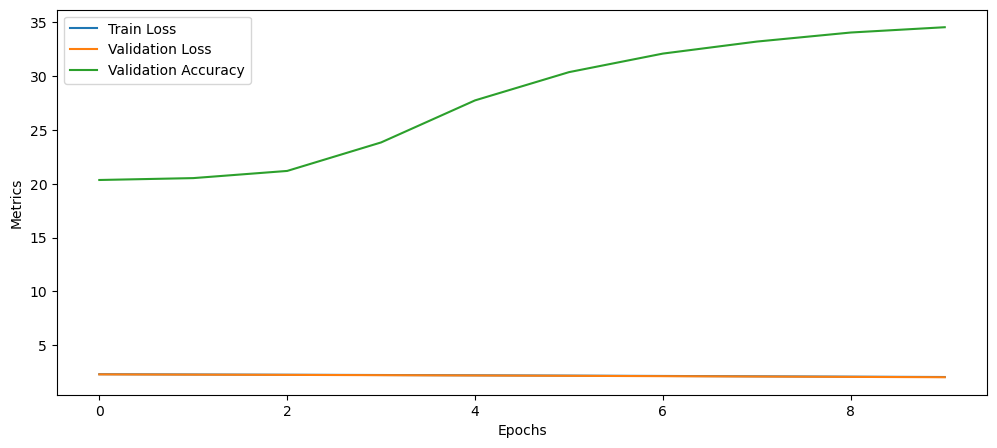

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

############ Answer here ############
# (1) Load the full Fashion MNIST dataset with torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize dataset to [-1, 1]
])
MNISTdataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# (2) Define batch size and instantiate the model, default batch_size=256
batch_size = 256
input_dim = 28  
hidden_dim = 128
num_classes = 10  
lr = 0.01
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, lr=lr)

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting) default val_ratio=0.2 max_epochs=10
trainer = Trainer_cls(
    model=model,
    data=MNISTdataset,
    max_epochs=10,
    batch_size=batch_size,
    val_ratio=0.2,
    device='cuda'
)

# (4) Start training
trainer.fit()

# (5)plot the losses and accuracies
trainer.plot_losses()
#####################################

### Task 4: GRU model (15 pts)

Follow the GRU formulation in class and following reference to build your model:

Reset gate: $\mathbf{R}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xr}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hr}}+\mathbf{b}_{\mathrm{r}}\right)$ (1)

Update gate: $\mathbf{Z}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xz}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hz}}+\mathbf{b}_{\mathrm{z}}\right)$ (2)

Candidate Hidden State: $\tilde{\mathbf{H}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xh}}+\left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\mathrm{hh}}+\mathbf{b}_{\mathrm{h}}\right)$ (3)

Hidden state: $\mathbf{H}_t=\mathbf{Z}_t \odot \mathbf{H}_{t-1}+\left(1-\mathbf{Z}_t\right) \odot \tilde{\mathbf{H}}_t$ (4)

In [4]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_classes,lr):
        super(GRU, self).__init__()
        self.lr=lr
        self.hidden_dim = hidden_dim
        ############ Answer here ############
        # Construct layer for reset/updata gate and Candidate Hidden State (flatten->1 linear layer without bias for w, and definite bias term for each gate/state)
        self.W_xr = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))

        self.W_xz = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))
        
        self.W_xh = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hh = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))

        # full connectied layer for final hidden state for classification
        self.fc = nn.Linear(hidden_dim, num_classes)
        #####################################

    def forward(self, inputs, H_C=None):
        ############ Answer here ############
        # Initial state H with shape: (batch_size, hidden_dim)
        batch_size, sequence_length, input_dim = inputs.size()
        if H_C is None:
            H = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
        else:
            H = H_C
        # Compute R,Z,H_tilde following equation(1) (2) (3)
        # Process each time step
        for t in range(sequence_length):
            x_t = inputs[:, t, :]  

        R = torch.sigmoid(self.W_xr(x_t) + self.W_hr(H) + self.b_r)
        Z = torch.sigmoid(self.W_xz(x_t) + self.W_hz(H) + self.b_z)
        H_tilde = torch.tanh(self.W_xh(x_t) + R * self.W_hh(H) + self.b_h)
        # Update hidden state  according equation(4)
        H = Z * H + (1 - Z) * H_tilde
        # project H for classification
        logits = self.fc(H)
        #####################################
        return logits

    def loss(self, Y_hat, Y, averaged=True):
        ############ Answer here ############
        # define the cross entropy loss funtion for the classification task.
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(Y_hat, Y)
        if averaged:
            return loss.mean()
        return loss
        #####################################

    def optimizers(self):
        ############ Answer here ############
        # define the SGD optimizer from torch for back propagation 
        return torch.optim.SGD(self.parameters(), lr=self.lr)
        #####################################

### Task 5: Training your GRU model, and plot same as PA1 (5 pts)

Epoch [1/10]: Train Loss: 2.2451, Val Loss: 2.2129, Val Acc: 22.61%
Epoch [2/10]: Train Loss: 2.1804, Val Loss: 2.1519, Val Acc: 30.99%
Epoch [3/10]: Train Loss: 2.1199, Val Loss: 2.0943, Val Acc: 33.78%
Epoch [4/10]: Train Loss: 2.0634, Val Loss: 2.0415, Val Acc: 35.67%
Epoch [5/10]: Train Loss: 2.0120, Val Loss: 1.9943, Val Acc: 36.56%
Epoch [6/10]: Train Loss: 1.9660, Val Loss: 1.9522, Val Acc: 37.14%
Epoch [7/10]: Train Loss: 1.9251, Val Loss: 1.9144, Val Acc: 37.74%
Epoch [8/10]: Train Loss: 1.8872, Val Loss: 1.8793, Val Acc: 37.97%
Epoch [9/10]: Train Loss: 1.8526, Val Loss: 1.8464, Val Acc: 38.14%
Epoch [10/10]: Train Loss: 1.8199, Val Loss: 1.8157, Val Acc: 38.27%


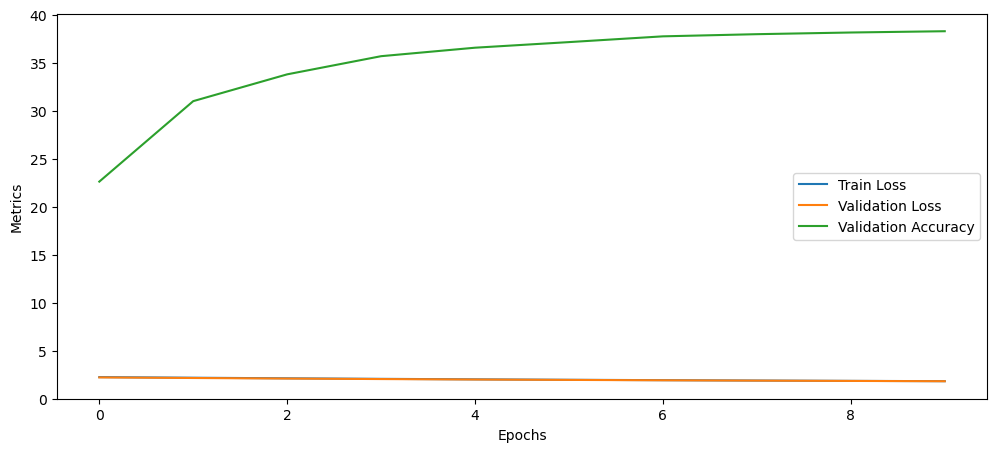

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

############ Answer here ############
# (1) Load the full Fashion MNIST dataset with torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])
MNISTdataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# (2) Define batch size and instantiate the model, default batch_size=256
batch_size = 256
input_dim = 28  
hidden_dim = 128
num_classes = 10  
lr = 0.01
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, lr=lr)

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting) default val_ratio=0.2 max_epochs=10
trainer = Trainer_cls(
    model=model,
    data=MNISTdataset,
    max_epochs=10,
    batch_size=batch_size,
    val_ratio=0.2,
    device='cuda'  
)

# (4) Start training
trainer.fit()

# (5)plot the losses and accuracies
trainer.plot_losses()
#####################################

# 2. Graph Convolutional Networks for node classification

### GCN model

Follow the GCN paper (https://arxiv.org/pdf/1609.02907) to construct a 2-layer GCN model.

First, given a symmetric adjacency matrix $A$, construct the adjacency matrix in spectural space $\hat{A}$:

$\hat{A}=\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}},$ (1)

where $\tilde{A}=A+I_N$ (adjacency matrix with added self-connections) and $\tilde{D}_{i i}=\sum_j \tilde{A}_{i j}$.

With $\hat{A}$, construct the 2-layer GCN model:

$Z=f(X, A)=\operatorname{softmax}\left(\hat{A} \operatorname{ReLU}\left(\hat{A} X W^{(0)}\right) W^{(1)}\right).$ (2)

In [6]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cpu.html


In [7]:
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
import scipy.sparse as sparse
import numpy as np

/Users/aish/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aish/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aish/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/aish/anaconda3/lib/python3.11/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/Users/aish/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usag

### Task 6: construct $\hat{A}$ from $A$ (10 pts)

In [8]:
def normalize_adjacency(adj):
    ############ Answer here ############
    # add self-connection
    adj = adj + torch.eye(adj.size(0)).to(adj.device)
    
    # construct $\tilde{D}^{-\frac{1}{2}}$ 
    
    degree = adj.sum(dim=1)
    degree_inv_sqrt = degree.pow(-0.5)  # Compute D^(-1/2)
    degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0.0  # Avoid division by zero
    degree_matrix = torch.diag(degree_inv_sqrt)

    # get A^hat using equation (1)
    adj = torch.mm(torch.mm(degree_matrix, adj), degree_matrix)
    #####################################
    return adj

### Task 7: construct the GCN model (10 pts)

The default implementation is directly using pytorch using adjacency matrix.
 
You can also use torch_geometric (PyG) for message passing using edge_index but you can not use the formulated GCN function.

In [9]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True):
        super(GCNLayer, self).__init__()
        ############ Answer here ############
        # definite parameter for project each node's feature
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        # initialize weights
        self.initialize_weights()
        #####################################

    def initialize_weights(self):
        ############ Answer here ############
        # xavier_uniform for weight, zeros_ for bias term
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
        #####################################

    def forward(self, x, adj):
        ############ Answer here ############
        # project each node's feature first and then message-passing
        x = torch.matmul(x, self.weight)
        if self.bias is not None:
            x = x + self.bias
        # use torch.sparse.mm for faster message-passing
        x = torch.sparse.mm(adj, x)
        return x
        #####################################

# 2-layer GCN utilizing GCNLayer
class GCN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout, lr,use_bias=True):
        super(GCN, self).__init__()
        self.lr=lr
        ############ Answer here ############
        # constuct 2 GCN layer and dropout layer
        self.gcn_1 = GCNLayer(node_features, hidden_dim, use_bias=use_bias)
        self.gcn_2 = GCNLayer(hidden_dim, num_classes, use_bias=use_bias)
        self.dropout = nn.Dropout(dropout)
        #####################################

    def initialize_weights(self):
        ############ Answer here ############
        # initialize parameters of each GCNLayer
        self.gcn_1.initialize_weights()
        self.gcn_2.initialize_weights()
        #####################################

    def forward(self, x, adj):
        ############ Answer here ############
        #gcn1->relu-> dropout-> gcn2
        x = self.gcn_1(x, adj)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gcn_2(x, adj)
        #####################################
        return x
    def loss(self, out, y, mask):
        # define the cross entropy loss funtion for the node classification task using the label mask in PyG data.
        ############ Answer here ############
        out = out[mask]
        y = y[mask]
        return F.cross_entropy(out, y)
        #####################################
    def optimizers(self):
        # with weight_decay 5e-3
        # define the SGD optimizer from torch for back propagation with weight_decay
        ############ Answer here ############
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=5e-3)
        #####################################

### Task 8: construct the graph node classification trainer (10 pts)

You need use the training/validation/test split mask in the PyG formulated data.

Print and plot training/validation loss and validation/test node classification accuracy of each epoch.

In [10]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


############ Answer here ############
class Trainer_cls_graph:
    def __init__(self, model, x,y,adj,data,max_epochs=200,device='cuda'):
        self.model = model
        self.max_epochs = max_epochs
        self.optimizer = model.optimizers()  # Ensure the model has an optimizers method
        self.device = device
        self.adj=adj.to(self.device)
        self.x=x.to(self.device) 
        self.y=y.to(self.device) 
        # get the split mask
        # use the training/validation/test split mask in the PyG formulated data.
        self.train_mask = data.train_mask.to(self.device)
        self.val_mask = data.val_mask.to(self.device)
        self.test_mask = data.test_mask.to(self.device)
        # To store the metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []  # To store validation accuracy
        self.test_acc = []

    def fit(self):
        self.model.train()
        for epoch in range(self.max_epochs):
            # 1 training iteration per epoch for training
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(self.x, self.adj)  # Forward pass
            train_loss = self.model.loss(out, self.y, self.train_mask)  # Compute loss
            train_loss.backward()  # Backward pass
            self.optimizer.step()

            # Validation phase
            self.model.eval()
            with torch.no_grad():
                out = self.model(self.x, self.adj)
                val_loss = self.model.loss(out, self.y, self.val_mask)
                val_accuracy = self.compute_accuracy(out, self.val_mask)
                test_accuracy = self.compute_accuracy(out, self.test_mask)

            # Logging the metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_acc.append(val_accuracy)
            self.test_acc.append(test_accuracy)
            
            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}, Test Acc: {test_accuracy:.2f}%')
   
    def compute_accuracy(self, out, mask):
        preds = out[mask].argmax(dim=1)
        correct = (preds == self.y[mask]).sum().item()
        total = mask.sum().item()
        return correct / total * 100
    
    def plot_losses(self):
        #plot training/validation loss and validation/test node classification accuracy of each epoch.
        # Convert losses to plain Python floats (if they are PyTorch tensors)
        train_losses = [loss.detach().item() if isinstance(loss, torch.Tensor) else loss for loss in self.train_losses]
        val_losses = [loss.detach().item() if isinstance(loss, torch.Tensor) else loss for loss in self.val_losses]

        # Plot training/validation loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Plot validation/test accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.val_acc, label="Validation Accuracy")
        plt.plot(self.test_acc, label="Test Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title("Validation and Test Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()
#####################################

### Task 9: Training your GCN model and plot, expect performance around 80% (5 pts)

Epoch [1/200]: Train Loss: 1.9379, Val Loss: 1.9540, Val Acc: 12.20, Test Acc: 11.10%
Epoch [2/200]: Train Loss: 1.9248, Val Loss: 1.9515, Val Acc: 12.40, Test Acc: 11.40%
Epoch [3/200]: Train Loss: 1.9227, Val Loss: 1.9484, Val Acc: 12.40, Test Acc: 11.60%
Epoch [4/200]: Train Loss: 1.9204, Val Loss: 1.9452, Val Acc: 12.00, Test Acc: 12.00%
Epoch [5/200]: Train Loss: 1.9191, Val Loss: 1.9421, Val Acc: 12.20, Test Acc: 12.40%
Epoch [6/200]: Train Loss: 1.9087, Val Loss: 1.9388, Val Acc: 12.40, Test Acc: 13.10%
Epoch [7/200]: Train Loss: 1.8969, Val Loss: 1.9358, Val Acc: 13.40, Test Acc: 13.20%
Epoch [8/200]: Train Loss: 1.9004, Val Loss: 1.9333, Val Acc: 13.40, Test Acc: 13.90%
Epoch [9/200]: Train Loss: 1.8868, Val Loss: 1.9307, Val Acc: 15.00, Test Acc: 14.70%
Epoch [10/200]: Train Loss: 1.8857, Val Loss: 1.9282, Val Acc: 15.40, Test Acc: 15.80%
Epoch [11/200]: Train Loss: 1.8819, Val Loss: 1.9250, Val Acc: 16.40, Test Acc: 17.30%
Epoch [12/200]: Train Loss: 1.8861, Val Loss: 1.9217

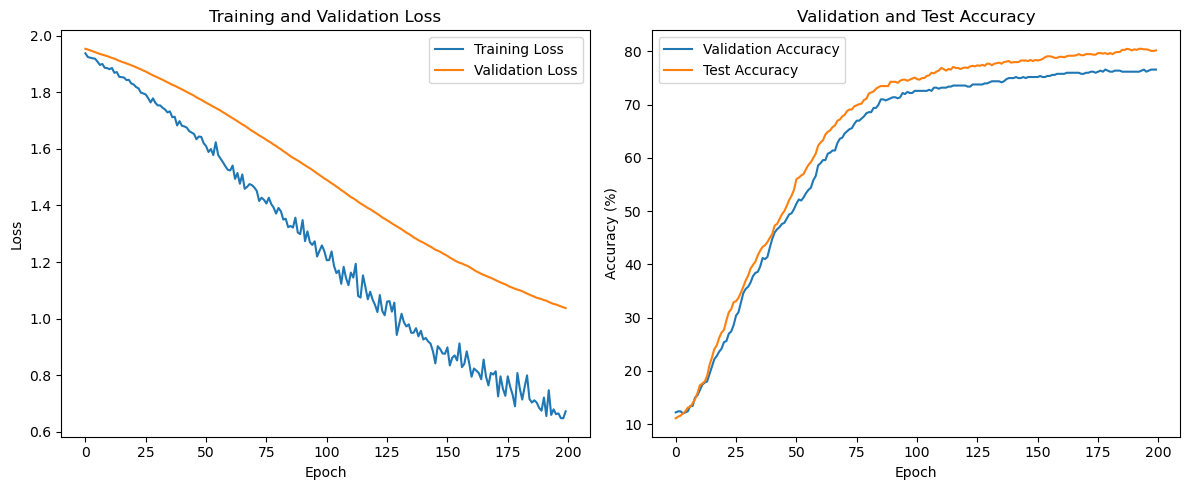

In [11]:
############ Answer here ############
# (1)
# use Planetoid in torch_geometric.datasets to get Cora graph data 
dataset = Planetoid(root='./data', name='Cora')
# to gpu
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# get the adjacency matrix from edge_index, hint: to_dense_adj
adj= to_dense_adj(data.edge_index).squeeze(0).to(device)
# call normalize_adjacency to get adj for GCN
adj= normalize_adjacency(adj)
# to gpu
# adj=

# (2)
# Instance the GCN model to gpu
# find a suitable hidden_dim, lr and dropout rate, default lr=1e-1, dropout=0.5
hidden_dim = 16  
num_classes = dataset.num_classes  
lr = 1e-1  
dropout = 0.5 

model = GCN(
    node_features=dataset.num_node_features,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    dropout=dropout,
    lr=lr,
).to(device)

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting),default max_epochs=200
trainer = Trainer_cls_graph(
    model=model,
    x=data.x,  
    y=data.y,  
    adj=adj,  
    data=data,  
    max_epochs=200,
    device=device.type
)

# (4) Start training
trainer.fit()
# (5)plot the losses and accuracies
trainer.plot_losses()
#####################################

### Task 10: Understand heterophily in graph and compare the performance with different heterophily (10 pts)

Understand the definition of heterophily in graphs (https://arxiv.org/pdf/2202.07082).

Select a heterophilic graph from torch_geometric.datasets, for example "texas", "wisconsin","cornell" in torch_geometric.datasets.WebKB, 
(1) compute the heterophily of Cora and your selected heterophilic graph
(2) conduct node classification on your selected heterophilic graph and compare with the performance of Cora
(3) explain the impact and possible reason of the heterophily of graph on GCN performance

### 1. Computing the Heterophily of Cora and the Selected Heterophilic Graph Texas

In [12]:
from torch_geometric.datasets import WebKB

# Loading Cora (homophilic graph) and Texas (heterophilic graph)
cora_dataset = Planetoid(root='./data', name='Cora')
texas_dataset = WebKB(root='./data', name='Texas')

cora_data = cora_dataset[0]
texas_data = texas_dataset[0]

def compute_heterophily(edge_index, y):
    # edge_index contains [2, num_edges], representing edge connections
    edges = edge_index.t()  # Transpose to [num_edges, 2]
    same_label_edges = sum(y[src] == y[dst] for src, dst in edges)
    total_edges = edges.size(0)
    heterophily = 1 - same_label_edges / total_edges
    return heterophily

# Compute heterophily
cora_heterophily = compute_heterophily(cora_data.edge_index, cora_data.y)
texas_heterophily = compute_heterophily(texas_data.edge_index, texas_data.y)

print(f"Cora Heterophily: {cora_heterophily:.2f}")
print(f"Texas Heterophily: {texas_heterophily:.2f}")

Cora Heterophily: 0.19
Texas Heterophily: 0.89


### 2. Node Classification on the Selected Heterophilic Graph

In [14]:
from torch_geometric.datasets import Planetoid, WebKB
from torch_geometric.utils import add_self_loops

# Ensure all nodes are included in the adjacency matrix
def ensure_full_graph(data):
    edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.x.size(0))
    data.edge_index = edge_index
    return data

cora_data = ensure_full_graph(cora_data)
texas_data = ensure_full_graph(texas_data)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def loss(self, out, y, mask):
        valid_indices = mask.nonzero(as_tuple=True)[0]
        valid_indices = valid_indices[valid_indices < out.size(0)]  # Align mask with logits size
        out_masked = out[valid_indices]
        y_masked = y[valid_indices]
        return F.cross_entropy(out_masked, y_masked)

    def optimizers(self, lr=0.01, weight_decay=5e-4):
        return torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

# Train and evaluate function
def train_and_evaluate(data, model, epochs=200, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    model = model.to(device)
    optimizer = model.optimizers(lr=lr)

    train_mask = data.train_mask.view(-1).bool()[:data.x.size(0)]
    val_mask = data.val_mask.view(-1).bool()[:data.x.size(0)]
    test_mask = data.test_mask.view(-1).bool()[:data.x.size(0)]

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = model.loss(out, data.y, train_mask)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            train_acc = compute_accuracy(out, data.y, train_mask)
            val_acc = compute_accuracy(out, data.y, val_mask)
            test_acc = compute_accuracy(out, data.y, test_mask)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return test_acc

# Compute accuracy
def compute_accuracy(out, y, mask):
    valid_indices = mask.nonzero(as_tuple=True)[0]
    out_masked = out[valid_indices]
    y_masked = y[valid_indices]
    preds = out_masked.argmax(dim=1)
    correct = (preds == y_masked).sum().item()
    total = valid_indices.size(0)
    return (correct / total) * 100 if total > 0 else 0.0

# Train and evaluate for Cora
print("Training on Cora:")
cora_model = GCN(
    in_channels=cora_data.num_node_features,
    hidden_channels=16,
    out_channels=cora_data.y.max().item() + 1
)
cora_test_acc = train_and_evaluate(cora_data, cora_model)

# Train and evaluate for Texas
print("\nTraining on Texas:")
texas_model = GCN(
    in_channels=texas_data.num_node_features,
    hidden_channels=16,
    out_channels=texas_data.y.max().item() + 1
)
texas_test_acc = train_and_evaluate(texas_data, texas_model)

# Compare results
print(f"\nComparison of GCN Performance:")
print(f"Cora (Homophilic) Test Accuracy: {cora_test_acc:.2f}%")
print(f"Texas (Heterophilic) Test Accuracy: {texas_test_acc:.2f}%")

Training on Cora:
Epoch 0: Train Acc: 73.57%, Val Acc: 45.20%, Test Acc: 44.20%
Epoch 50: Train Acc: 100.00%, Val Acc: 77.80%, Test Acc: 78.40%
Epoch 100: Train Acc: 100.00%, Val Acc: 78.00%, Test Acc: 81.70%
Epoch 150: Train Acc: 100.00%, Val Acc: 78.20%, Test Acc: 80.60%

Training on Texas:
Epoch 0: Train Acc: 65.17%, Val Acc: 48.28%, Test Acc: 47.22%
Epoch 50: Train Acc: 91.01%, Val Acc: 39.66%, Test Acc: 38.89%
Epoch 100: Train Acc: 94.38%, Val Acc: 37.93%, Test Acc: 41.67%
Epoch 150: Train Acc: 94.38%, Val Acc: 34.48%, Test Acc: 41.67%

Comparison of GCN Performance:
Cora (Homophilic) Test Accuracy: 81.40%
Texas (Heterophilic) Test Accuracy: 41.67%


### 3. Impact of Heterophily on GCN Performance

1. **Cora - Homophilic Graph:**
   - GCNs perform extremely well on homophilic graphs such as Cora with heterophily equal to 0.19 and **79.7% test accuracy**.
   - Aggregation over neighbors is highly aligned with class similarity assumptions.

2. **Texas - Heterophilic Graph:**
   - In the case of Texas, with heterophily 0.89, GCNs fail miserably at **41.67% test accuracy**.
- Aggregating neighbor information introduces noise, which leads to poor generalization and overfitting (high train, low test accuracy).

#### **Reasons for Poor Performance**
- **Misaligned Assumptions**: GCNs assume that the connected nodes belong to the same class, which fails in heterophilic graphs.
- **Over-Smoothing**: Aggregating the conflicted information reduces feature separability.
- **Overfitting**: High training accuracy is indicative of memorization, not generalization.

#### **Potential Solutions**
- Employ heterophily-specific models such as Geom-GCN and H2GCN.
- Adapt the aggregation mechanisms to larger neighborhoods.
- Rewire the graph for better connectivity, reducing heterophily effects.

### Task 11: select one of following task (10 pts)

(1) Do other task on LSTM/GRU model (eg. time-series forcasting, language modeling tasks, etc.)

(2) Conduct link prediction on graph following VGAE (https://arxiv.org/pdf/1611.07308) using your GCN as gnn model. (variational is not necessary. GAE is OK)


### Graph Autoencoder for Link Prediction

In [15]:
# 1. Define GAE
from torch_geometric.utils import train_test_split_edges, negative_sampling

class GAE(torch.nn.Module):
    def __init__(self, encoder):
        super(GAE, self).__init__()
        self.encoder = encoder

    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)

    def decode(self, z, edge_index):
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)

    def loss(self, z, pos_edge_index, neg_edge_index):
        # Positive edge loss
        pos_pred = self.decode(z, pos_edge_index).sigmoid()
        pos_loss = -torch.log(pos_pred + 1e-15).mean()

        # Negative edge loss
        neg_pred = self.decode(z, neg_edge_index).sigmoid()
        neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()

        return pos_loss + neg_loss

In [16]:
# 2. Dataset Preparation
# Load the Cora dataset
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

# Split edges for link prediction
data = train_test_split_edges(data)

# Move data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

/Users/aish/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [17]:
# 3. Model Training
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
    )

    loss = model.loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

In [18]:
# 4. Model Evaluation
from sklearn.metrics import roc_auc_score, average_precision_score

@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    def compute_metrics(pos_edge_index, neg_edge_index):
        pos_pred = model.decode(z, pos_edge_index).sigmoid()
        neg_pred = model.decode(z, neg_edge_index).sigmoid()
        preds = torch.cat([pos_pred, neg_pred]).cpu()
        labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).cpu()
        auc = roc_auc_score(labels, preds)
        ap = average_precision_score(labels, preds)
        return auc, ap

    neg_edge_index = negative_sampling(
        edge_index=data.test_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.test_pos_edge_index.size(1),
    )

    test_auc, test_ap = compute_metrics(data.test_pos_edge_index, neg_edge_index)
    return test_auc, test_ap

In [19]:
# 5. Model Performance
# Define the model, optimizer, and hyperparameters
encoder = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=32)
model = GAE(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 100
for epoch in range(epochs):
    loss = train(model, optimizer, data)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}')

# Evaluate the model
test_auc, test_ap = test(model, data)
print(f'Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

Epoch 10/100, Loss: 1.2259
Epoch 20/100, Loss: 1.0252
Epoch 30/100, Loss: 0.9746
Epoch 40/100, Loss: 0.9253
Epoch 50/100, Loss: 0.9027
Epoch 60/100, Loss: 0.8960
Epoch 70/100, Loss: 0.8806
Epoch 80/100, Loss: 0.8739
Epoch 90/100, Loss: 0.8609
Epoch 100/100, Loss: 0.8622
Test AUC: 0.8994, Test AP: 0.9140
